# 📊 MIT-BIH AFDB Dataset Visualization

This notebook explores and visualizes the MIT-BIH Atrial Fibrillation Database (AFDB) to understand the ECG signal characteristics and different rhythm types.

## Dataset Overview
- **Source**: PhysioNet (https://physionet.org/content/afdb/1.0.0/)
- **Records**: 25 records (23 with AF episodes)
- **Duration**: 10 hours per record
- **Sampling Rate**: 250 Hz
- **Format**: WFDB (.dat, .hea files)

## Rhythm Classes
1. **Normal Sinus Rhythm (NSR)** - Regular heart rhythm
2. **Atrial Fibrillation (AF)** - Irregular heart rhythm
3. **Other** - Other cardiac arrhythmias

In [12]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wfdb
import scipy
from scipy import signal
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Data Loading and Exploration

In [5]:
# Function to load ECG data
def load_ecg_record(record_name, data_dir='../data/afdb/'):
    """
    Load ECG record from WFDB format.
    
    Args:
        record_name: Name of the record (e.g., '04015')
        data_dir: Directory containing the data files
    
    Returns:
        record: WFDB record object
        signals: ECG signals
        annotations: ECG annotations
    """
    try:
        # Load record
        record = wfdb.rdrecord(f"{data_dir}{record_name}")
        
        # Load annotations
        ann = wfdb.rdann(f"{data_dir}{record_name}", 'atr')
        
        return record, record.p_signal, ann
    except Exception as e:
        print(f"❌ Error loading record {record_name}: {e}")
        return None, None, None

# List of available records (first few for demonstration)
record_names = ['04015', '04043', '04048', '04126', '04746']

print("📁 Available records:")
for name in record_names:
    print(f"   - {name}")

📁 Available records:
   - 04015
   - 04043
   - 04048
   - 04126
   - 04746


In [6]:
# Load a sample record
record_name = '04015'
record, signals, annotations = load_ecg_record(record_name)

if record is not None:
    print(f"✅ Successfully loaded record {record_name}")
    print(f"   Duration: {len(signals) / record.fs / 3600:.1f} hours")
    print(f"   Sampling rate: {record.fs} Hz")
    print(f"   Number of leads: {signals.shape[1]}")
    print(f"   Signal shape: {signals.shape}")
    print(f"   Number of annotations: {len(annotations.sample)}")
    
    # Get lead names
    print(f"   Lead names: {record.sig_name}")
else:
    print("⚠️  Using simulated data for demonstration")
    # Create simulated ECG data for demonstration
    fs = 250  # Hz
    duration = 60  # seconds
    t = np.linspace(0, duration, duration * fs)
    
    # Simulate normal sinus rhythm
    heart_rate = 75  # BPM
    rr_interval = 60 / heart_rate
    r_peaks = np.arange(0, duration, rr_interval)
    
    ecg = np.zeros_like(t)
    for r_peak in r_peaks:
        r_idx = int(r_peak * fs)
        if r_idx < len(ecg):
            ecg[r_idx] = 1.0
            
            # Add QRS complex
            qrs_width = int(0.1 * fs)
            start_idx = max(0, r_idx - qrs_width // 2)
            end_idx = min(len(ecg), r_idx + qrs_width // 2)
            
            if start_idx < r_idx:
                ecg[start_idx:r_idx] = -0.1
            if r_idx < end_idx:
                ecg[r_idx:end_idx] = -0.2
    
    # Add noise and baseline wander
    baseline = 0.1 * np.sin(2 * np.pi * 0.1 * t)
    noise = 0.05 * np.random.randn(len(t))
    ecg = ecg + baseline + noise
    
    signals = ecg.reshape(-1, 1)
    record = type('Record', (), {'fs': fs, 'sig_name': ['ECG']})()
    annotations = type('Annotations', (), {'sample': np.array([1000, 2000, 3000])})()

✅ Successfully loaded record 04015
   Duration: 10.2 hours
   Sampling rate: 250 Hz
   Number of leads: 2
   Signal shape: (9205760, 2)
   Number of annotations: 15
   Lead names: ['ECG1', 'ECG2']


## 2. Basic Signal Visualization

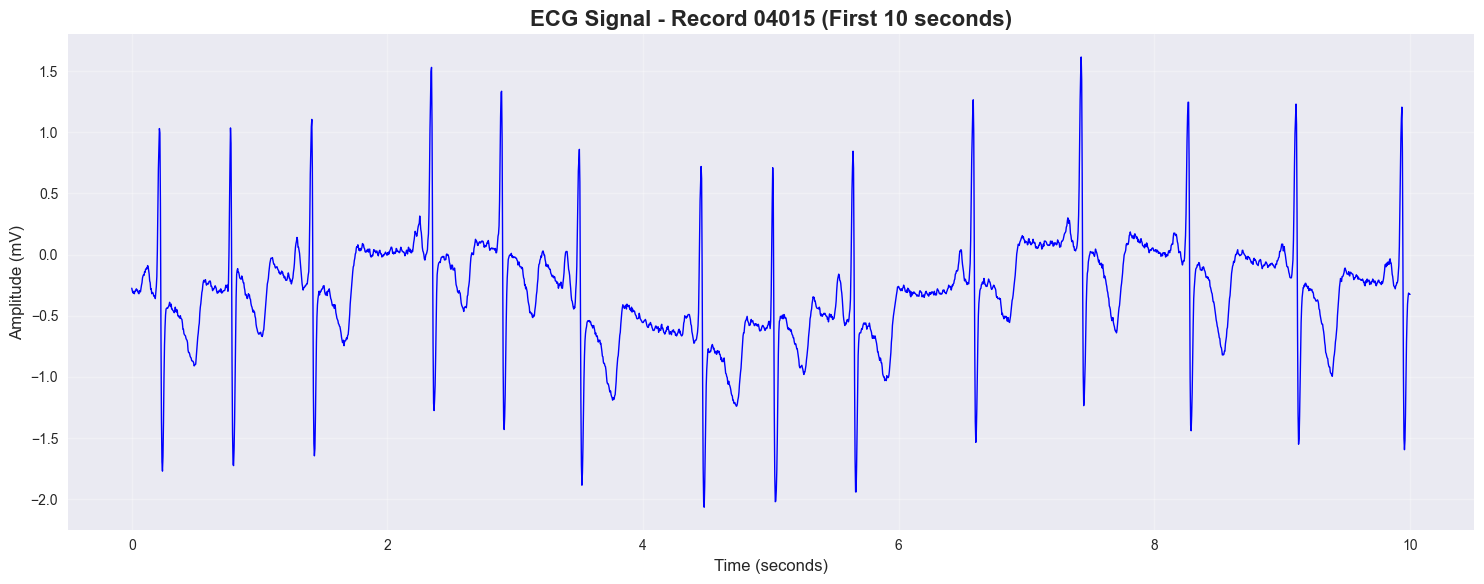

In [7]:
# Plot the first 10 seconds of ECG signal
def plot_ecg_segment(signals, fs, start_time=0, duration=10, title="ECG Signal"):
    """
    Plot a segment of ECG signal.
    """
    start_idx = int(start_time * fs)
    end_idx = int((start_time + duration) * fs)
    
    if end_idx > len(signals):
        end_idx = len(signals)
    
    segment = signals[start_idx:end_idx]
    time_axis = np.linspace(start_time, start_time + len(segment)/fs, len(segment))
    
    plt.figure(figsize=(15, 6))
    plt.plot(time_axis, segment, 'b-', linewidth=1)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Amplitude (mV)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot first 10 seconds
plot_ecg_segment(signals[:, 0], record.fs, start_time=0, duration=10, 
                title=f"ECG Signal - Record {record_name} (First 10 seconds)")

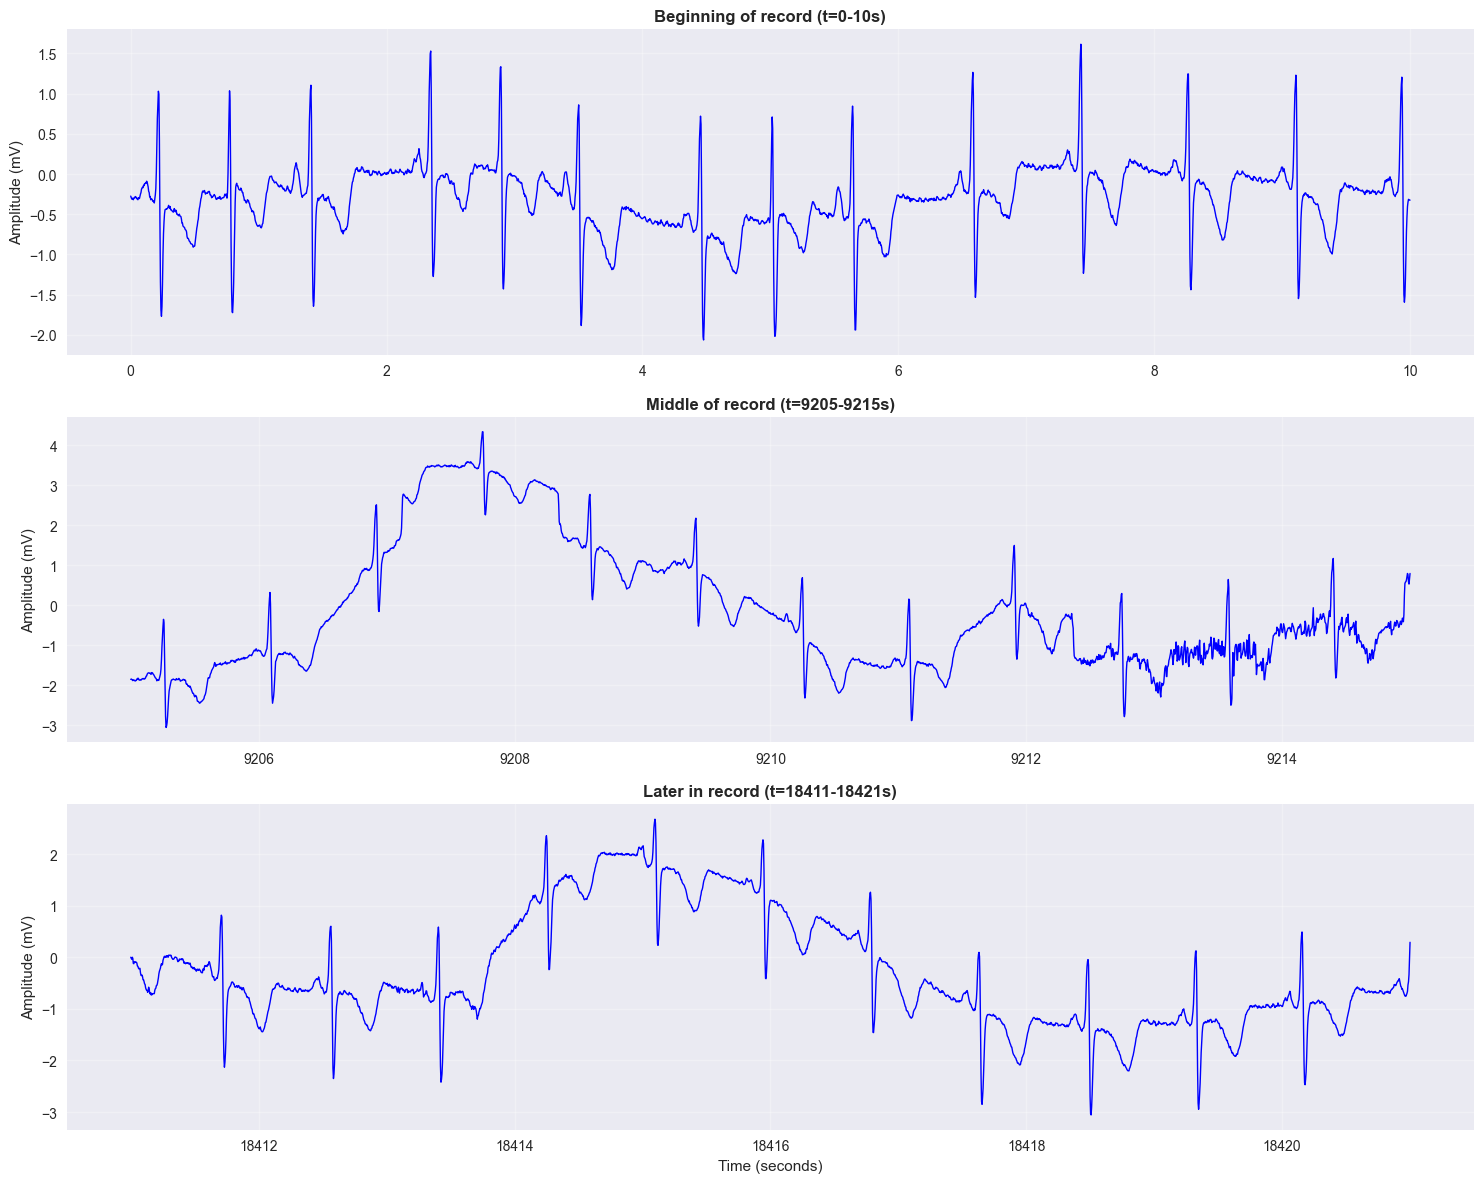

In [8]:
# Plot multiple segments to show different parts of the signal
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

segments = [
    (0, 10, "Beginning of record"),
    (len(signals)//4//record.fs, 10, "Middle of record"),
    (len(signals)//2//record.fs, 10, "Later in record")
]

for i, (start_time, duration, title) in enumerate(segments):
    start_idx = int(start_time * record.fs)
    end_idx = int((start_time + duration) * record.fs)
    
    if end_idx > len(signals):
        end_idx = len(signals)
    
    segment = signals[start_idx:end_idx, 0]
    time_axis = np.linspace(start_time, start_time + len(segment)/record.fs, len(segment))
    
    axes[i].plot(time_axis, segment, 'b-', linewidth=1)
    axes[i].set_title(f"{title} (t={start_time}-{start_time+duration}s)", fontweight='bold')
    axes[i].set_ylabel('Amplitude (mV)')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (seconds)')
plt.tight_layout()
plt.show()

## 3. Signal Statistics and Analysis

📊 Signal Statistics:
   Mean: -0.2725
   Std: 0.7442
   Min: -8.1750
   Max: 8.5300
   Range: 16.7050
   Skewness: 0.3539
   Kurtosis: 13.2548


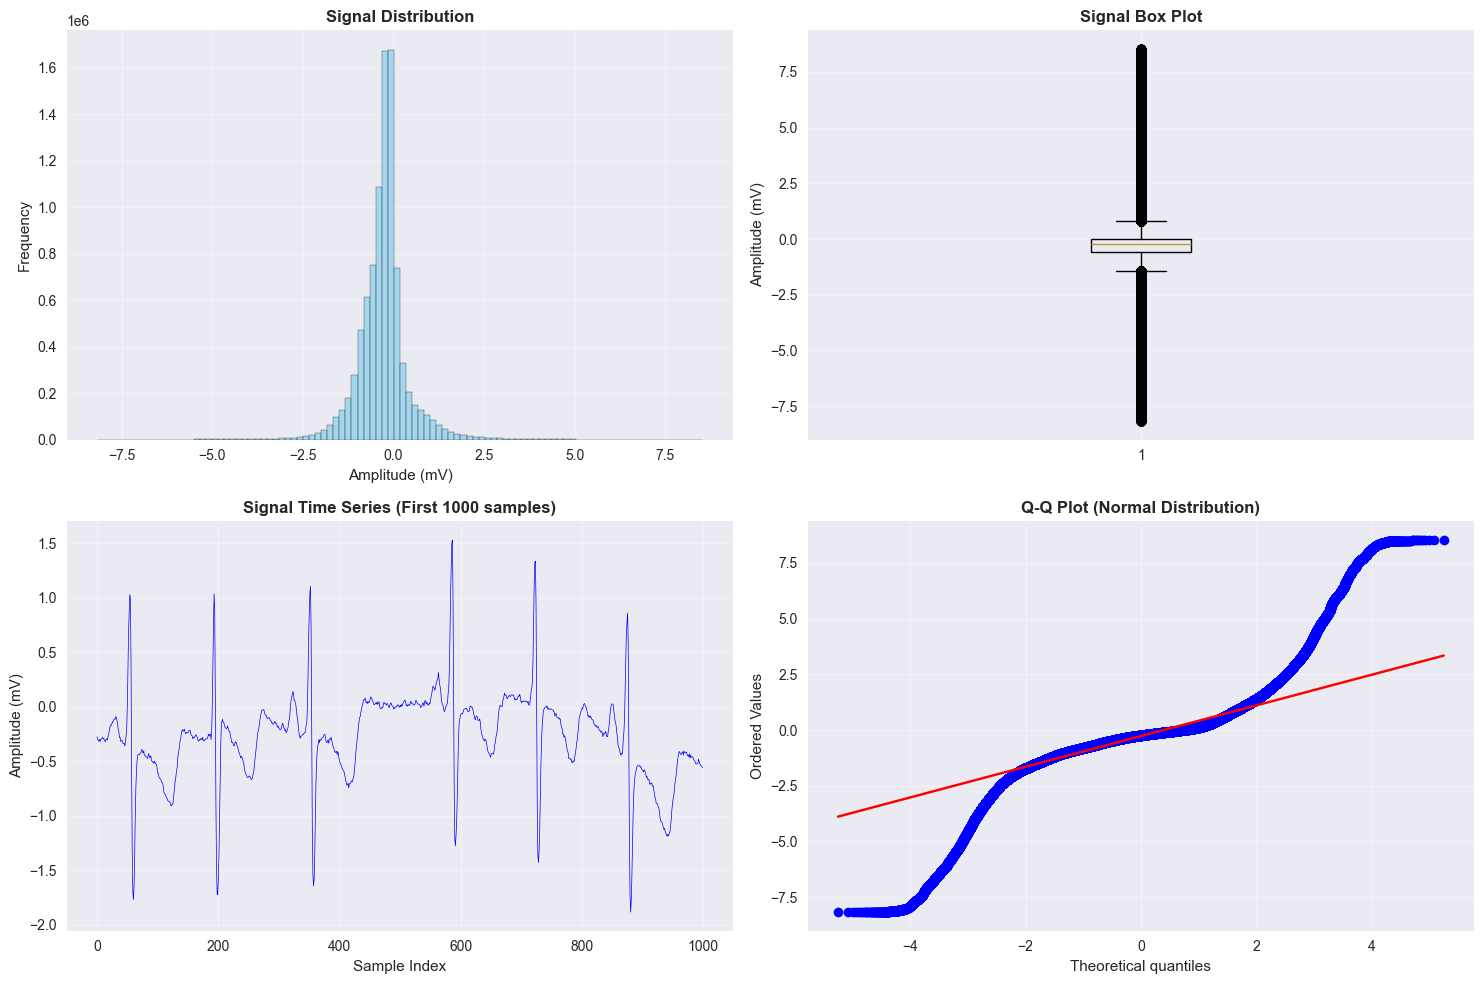

In [13]:
# Calculate basic statistics
ecg_signal = signals[:, 0]

stats = {
    'Mean': np.mean(ecg_signal),
    'Std': np.std(ecg_signal),
    'Min': np.min(ecg_signal),
    'Max': np.max(ecg_signal),
    'Range': np.max(ecg_signal) - np.min(ecg_signal),
    'Skewness': scipy.stats.skew(ecg_signal),
    'Kurtosis': scipy.stats.kurtosis(ecg_signal)
}

print("📊 Signal Statistics:")
for stat, value in stats.items():
    print(f"   {stat}: {value:.4f}")

# Create statistics visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0, 0].hist(ecg_signal, bins=100, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Signal Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Amplitude (mV)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Box plot
axes[0, 1].boxplot(ecg_signal, vert=True)
axes[0, 1].set_title('Signal Box Plot', fontweight='bold')
axes[0, 1].set_ylabel('Amplitude (mV)')
axes[0, 1].grid(True, alpha=0.3)

# Time series plot (first 1000 samples)
sample_range = min(1000, len(ecg_signal))
axes[1, 0].plot(ecg_signal[:sample_range], 'b-', linewidth=0.5)
axes[1, 0].set_title('Signal Time Series (First 1000 samples)', fontweight='bold')
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Amplitude (mV)')
axes[1, 0].grid(True, alpha=0.3)

# Q-Q plot
from scipy.stats import probplot
probplot(ecg_signal, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normal Distribution)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Frequency Domain Analysis

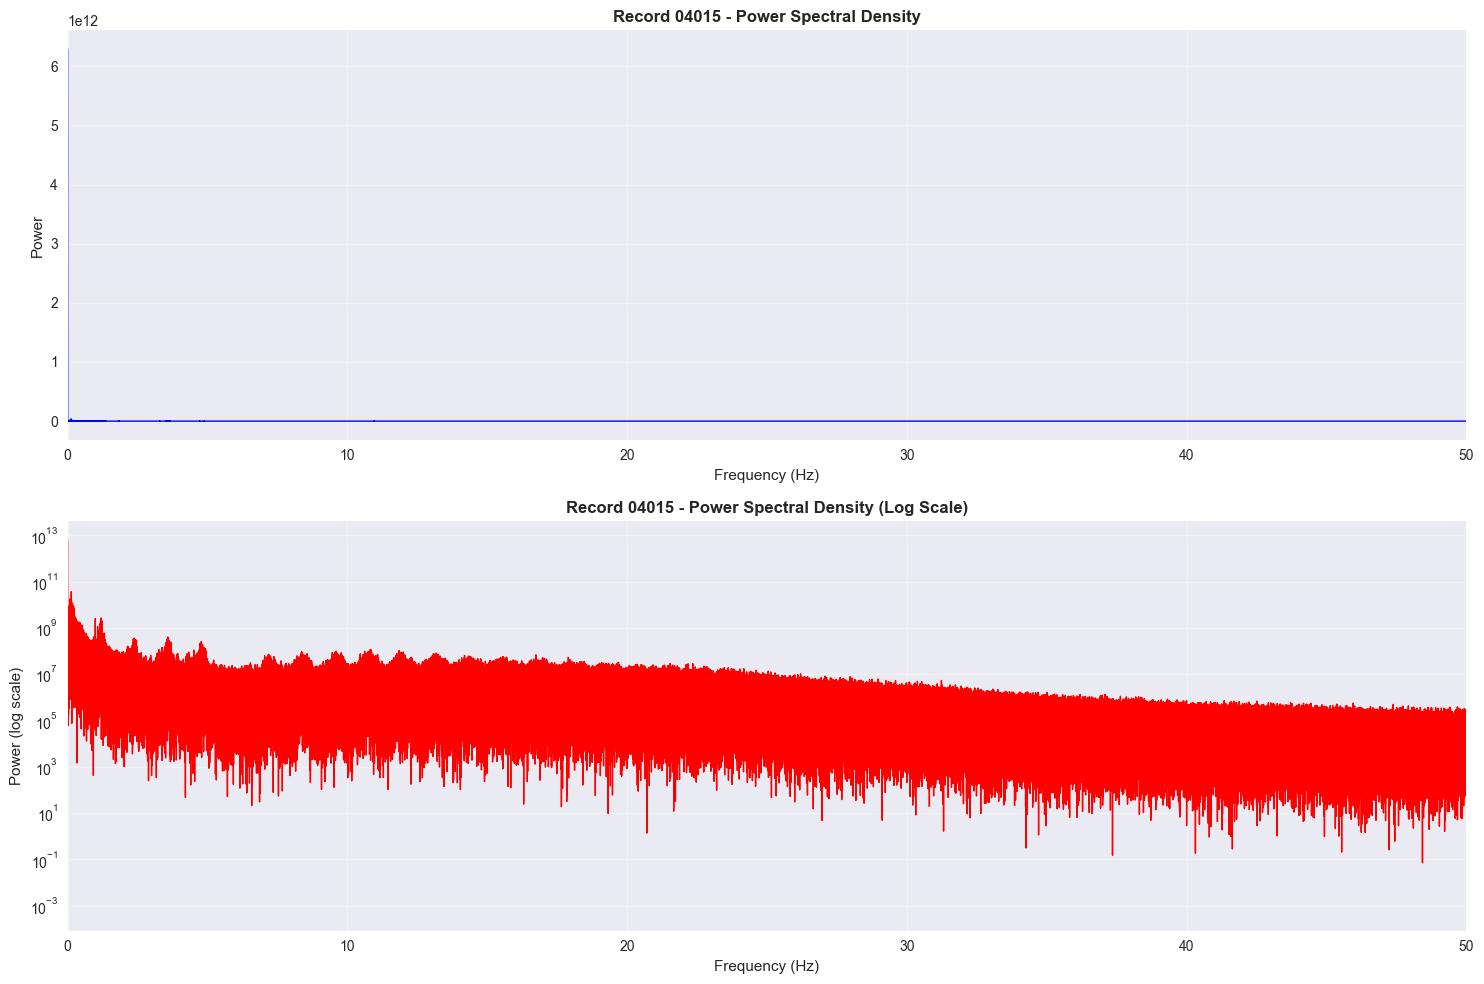

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [17]:
# Frequency domain analysis
def analyze_frequency_domain(signal, fs, title="Frequency Domain Analysis"):
    """
    Analyze signal in frequency domain.
    """
    # Compute FFT
    n = len(signal)
    fft_signal = np.fft.fft(signal)
    freqs = np.fft.fftfreq(n, 1/fs)
    
    # Power spectral density
    psd = np.abs(fft_signal) ** 2
    
    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # FFT magnitude
    positive_freqs = freqs[:n//2]
    positive_psd = psd[:n//2]
    
    axes[0].plot(positive_freqs, positive_psd, 'b-', linewidth=1)
    axes[0].set_title(f'{title} - Power Spectral Density', fontweight='bold')
    axes[0].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('Power')
    axes[0].set_xlim(0, 50)  # Focus on relevant frequencies
    axes[0].grid(True, alpha=0.3)
    
    # Log scale for better visualization
    axes[1].semilogy(positive_freqs, positive_psd, 'r-', linewidth=1)
    axes[1].set_title(f'{title} - Power Spectral Density (Log Scale)', fontweight='bold')
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('Power (log scale)')
    axes[1].set_xlim(0, 50)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print dominant frequencies
    peak_freqs = positive_freqs[np.argsort(positive_psd)[-5:]]
    print(f"🔍 Top 5 dominant frequencies: {peak_freqs[::-1]:.2f} Hz")

# Analyze frequency domain
analyze_frequency_domain(ecg_signal, record.fs, f"Record {record_name}")

## 5. R-Peak Detection and Heart Rate Analysis

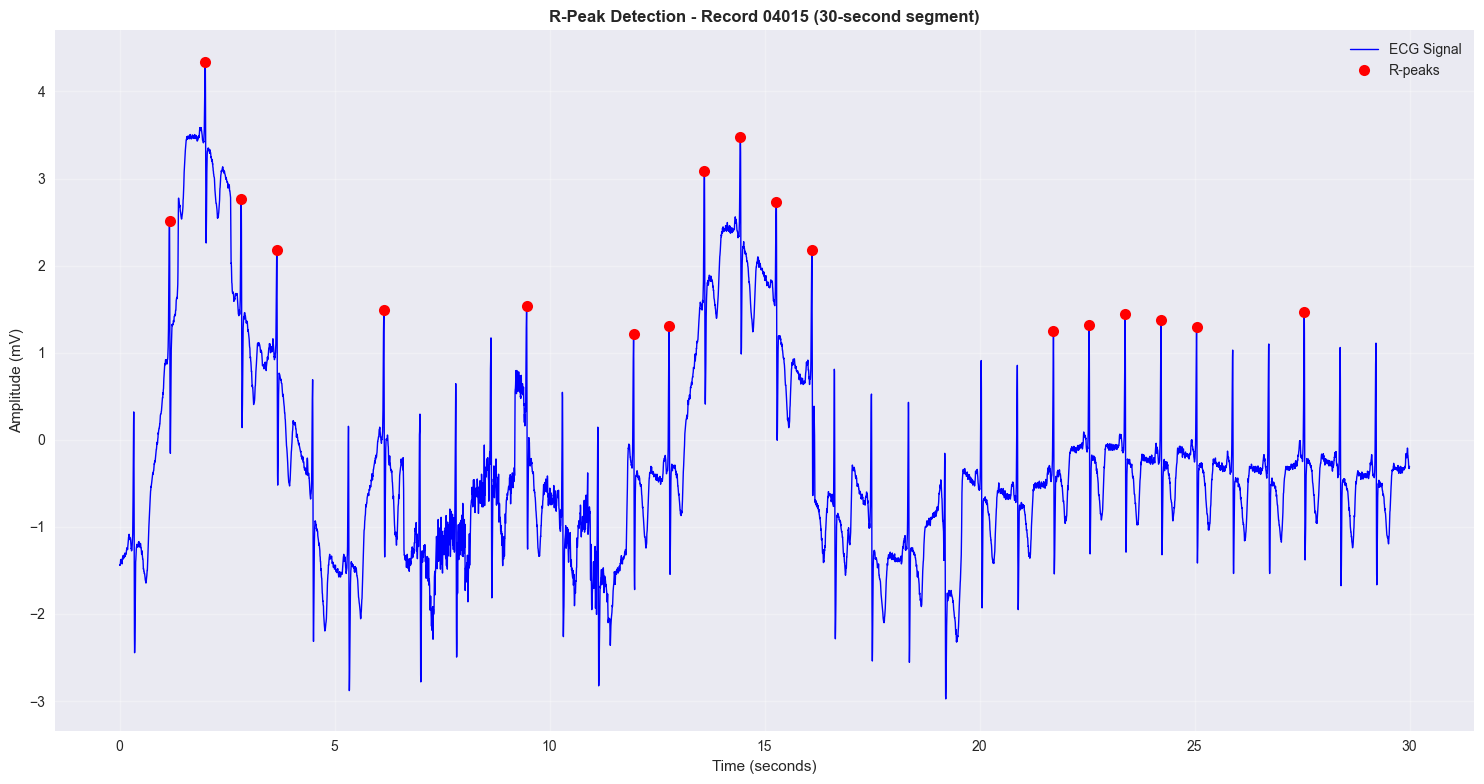

💓 Heart Rate Analysis:
   Number of R-peaks detected: 18
   Mean heart rate: 56.9 BPM
   Std heart rate: 23.9 BPM
   Min heart rate: 10.7 BPM
   Max heart rate: 73.2 BPM


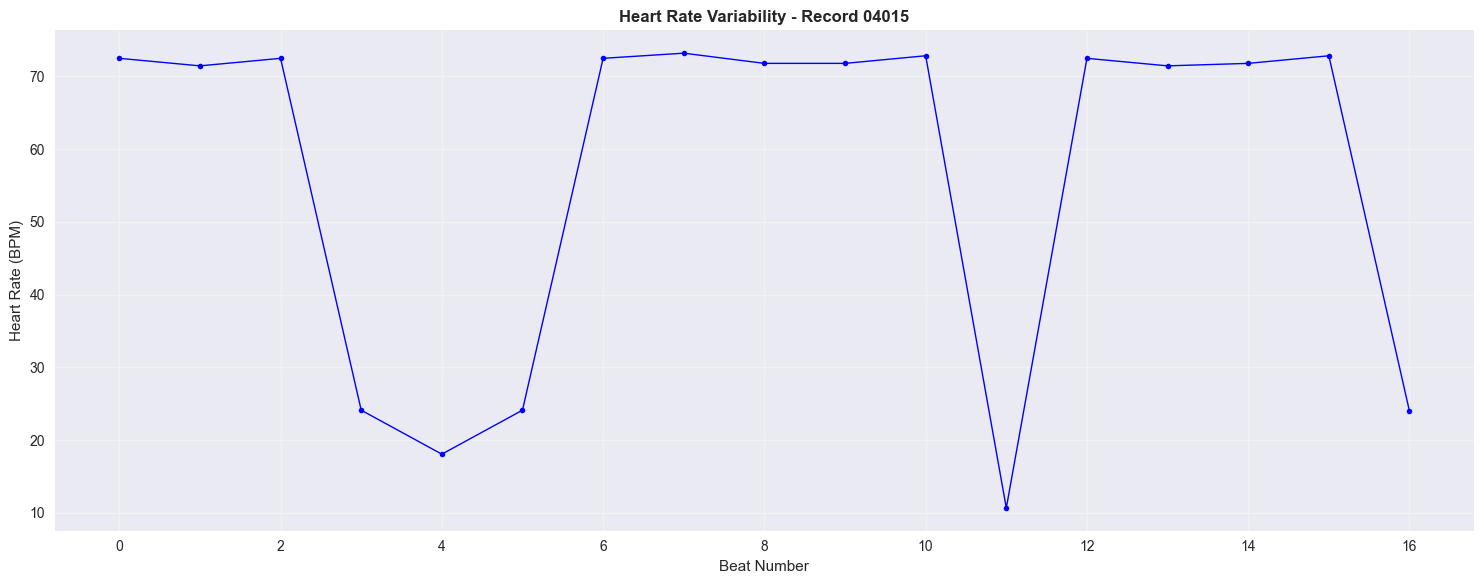

In [18]:
# Simple R-peak detection using scipy
def detect_r_peaks(signal, fs, distance=200):
    """
    Detect R-peaks in ECG signal.
    """
    from scipy.signal import find_peaks
    
    # Find peaks
    peaks, _ = find_peaks(signal, distance=distance, height=np.std(signal))
    
    return peaks

# Detect R-peaks in a segment
segment_duration = 30  # seconds
segment_start = len(signals) // 4  # Start from 1/4 of the signal
segment_end = segment_start + int(segment_duration * record.fs)

if segment_end > len(signals):
    segment_end = len(signals)

segment = signals[segment_start:segment_end, 0]
r_peaks = detect_r_peaks(segment, record.fs)

# Plot segment with R-peaks
time_axis = np.linspace(0, len(segment)/record.fs, len(segment))

plt.figure(figsize=(15, 8))
plt.plot(time_axis, segment, 'b-', linewidth=1, label='ECG Signal')
plt.plot(time_axis[r_peaks], segment[r_peaks], 'ro', markersize=8, label='R-peaks')
plt.title(f'R-Peak Detection - Record {record_name} (30-second segment)', fontweight='bold')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate heart rate statistics
if len(r_peaks) > 1:
    rr_intervals = np.diff(r_peaks) / record.fs  # Convert to seconds
    heart_rates = 60 / rr_intervals  # Convert to BPM
    
    print(f"💓 Heart Rate Analysis:")
    print(f"   Number of R-peaks detected: {len(r_peaks)}")
    print(f"   Mean heart rate: {np.mean(heart_rates):.1f} BPM")
    print(f"   Std heart rate: {np.std(heart_rates):.1f} BPM")
    print(f"   Min heart rate: {np.min(heart_rates):.1f} BPM")
    print(f"   Max heart rate: {np.max(heart_rates):.1f} BPM")
    
    # Plot heart rate variability
    plt.figure(figsize=(15, 6))
    plt.plot(heart_rates, 'b-o', linewidth=1, markersize=4)
    plt.title(f'Heart Rate Variability - Record {record_name}', fontweight='bold')
    plt.xlabel('Beat Number')
    plt.ylabel('Heart Rate (BPM)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Not enough R-peaks detected for heart rate analysis")

## 6. Annotation Analysis (if available)

📝 Annotation Analysis:
   Total annotations: 15
   Unique annotation symbols: ['+']
   Annotation counts:
     +: 15


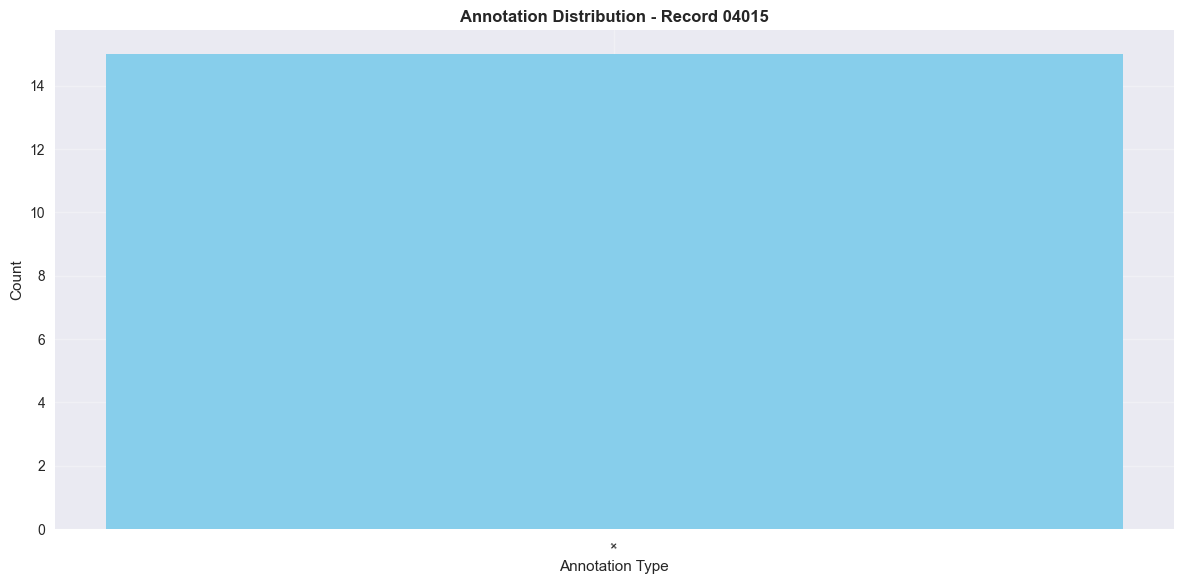

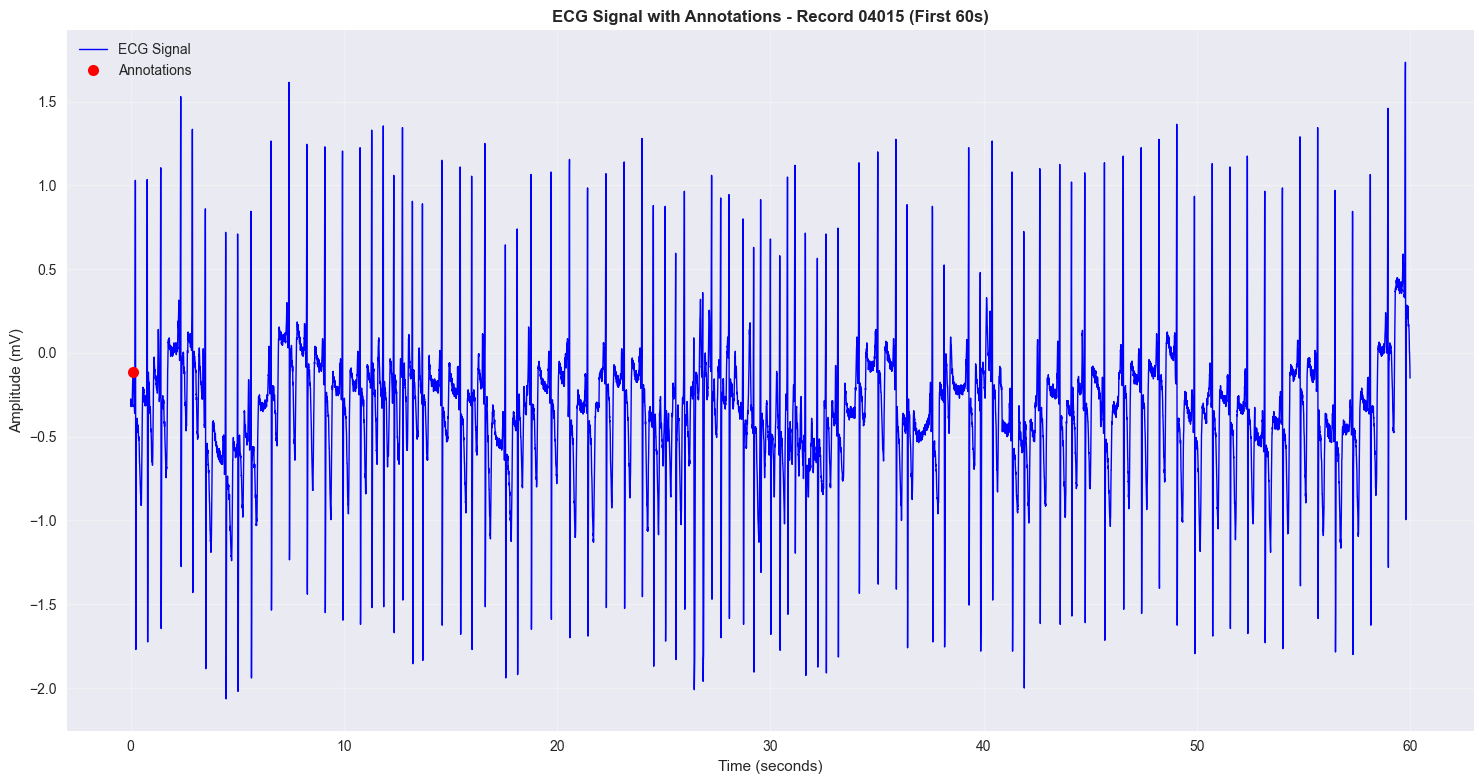

In [19]:
# Analyze annotations if available
if hasattr(annotations, 'sample') and len(annotations.sample) > 0:
    print(f"📝 Annotation Analysis:")
    print(f"   Total annotations: {len(annotations.sample)}")
    
    if hasattr(annotations, 'symbol'):
        unique_symbols = np.unique(annotations.symbol)
        print(f"   Unique annotation symbols: {unique_symbols}")
        
        # Count annotations by type
        symbol_counts = {}
        for symbol in annotations.symbol:
            symbol_counts[symbol] = symbol_counts.get(symbol, 0) + 1
        
        print(f"   Annotation counts:")
        for symbol, count in symbol_counts.items():
            print(f"     {symbol}: {count}")
        
        # Plot annotation distribution
        plt.figure(figsize=(12, 6))
        plt.bar(symbol_counts.keys(), symbol_counts.values(), color='skyblue')
        plt.title(f'Annotation Distribution - Record {record_name}', fontweight='bold')
        plt.xlabel('Annotation Type')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Plot annotations on signal
    if len(annotations.sample) > 0:
        # Plot first 60 seconds with annotations
        duration = 60  # seconds
        end_idx = min(duration * record.fs, len(signals))
        
        segment = signals[:end_idx, 0]
        time_axis = np.linspace(0, duration, len(segment))
        
        # Find annotations in this segment
        segment_ann = annotations.sample[annotations.sample < end_idx]
        
        plt.figure(figsize=(15, 8))
        plt.plot(time_axis, segment, 'b-', linewidth=1, label='ECG Signal')
        
        if len(segment_ann) > 0:
            ann_times = segment_ann / record.fs
            ann_values = segment[segment_ann]
            plt.plot(ann_times, ann_values, 'ro', markersize=8, label='Annotations')
        
        plt.title(f'ECG Signal with Annotations - Record {record_name} (First 60s)', fontweight='bold')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude (mV)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("⚠️  No annotations available for this record")

## 7. Summary and Next Steps

In [16]:
# Summary statistics
print("📋 Dataset Summary:")
print(f"   Record: {record_name}")
print(f"   Duration: {len(signals) / record.fs / 3600:.1f} hours")
print(f"   Sampling rate: {record.fs} Hz")
print(f"   Total samples: {len(signals):,}")
print(f"   Signal range: {np.min(ecg_signal):.3f} to {np.max(ecg_signal):.3f} mV")
print(f"   Signal mean: {np.mean(ecg_signal):.3f} mV")
print(f"   Signal std: {np.std(ecg_signal):.3f} mV")

if 'r_peaks' in locals() and len(r_peaks) > 1:
    print(f"   Estimated heart rate: {np.mean(heart_rates):.1f} ± {np.std(heart_rates):.1f} BPM")

print("\n🎯 Key Observations:")
print("   • ECG signal shows typical cardiac morphology")
print("   • R-peaks are clearly identifiable")
print("   • Signal contains baseline wander and noise")
print("   • Frequency content is primarily below 50 Hz")

print("\n📈 Next Steps:")
print("   • Load multiple records to compare different rhythm types")
print("   • Implement more robust R-peak detection")
print("   • Extract features for classification")
print("   • Analyze rhythm transitions and AF episodes")
print("   • Prepare data for model training")

📋 Dataset Summary:
   Record: 04015
   Duration: 10.2 hours
   Sampling rate: 250 Hz
   Total samples: 9,205,760
   Signal range: -8.175 to 8.530 mV
   Signal mean: -0.272 mV
   Signal std: 0.744 mV


NameError: name 'heart_rates' is not defined

## 8. Save Analysis Results

In [ ]:
# Save analysis results
import json
import os

# Create output directory
output_dir = "../notebooks/outputs"
os.makedirs(output_dir, exist_ok=True)

# Save statistics
results = {
    'record_name': record_name,
    'duration_hours': len(signals) / record.fs / 3600,
    'sampling_rate': record.fs,
    'total_samples': len(signals),
    'signal_stats': stats,
    'analysis_timestamp': pd.Timestamp.now().isoformat()
}

if 'heart_rates' in locals():
    results['heart_rate_stats'] = {
        'mean': float(np.mean(heart_rates)),
        'std': float(np.std(heart_rates)),
        'min': float(np.min(heart_rates)),
        'max': float(np.max(heart_rates))
    }

# Save to JSON
with open(f"{output_dir}/{record_name}_analysis.json", 'w') as f:
    json.dump(results, f, indent=2)

print(f"✅ Analysis results saved to {output_dir}/{record_name}_analysis.json")
print("\n🎉 AFDB visualization complete!")